# Transformers In Depth

> References :
1. [Attention is all you need (Original Paper)](https://arxiv.org/abs/1706.03762)
2. [Illustrated Transformers (Jay Alammar)](https://jalammar.github.io/illustrated-transformer/)
3. [Transformers From Scratch (e2eml)](https://e2eml.school/transformers.html)
4. [Math Behind Transformers (Srijit Mukherjee)](https://www.srijitmukherjee.com/the-math-behind-transformers/)
5. [Transformers From Scratch (Peter Bloem)](https://peterbloem.nl/blog/transformers)
6. [Transformer Architecture : The Positional Encoding (Amirhossein Kazemnejad's Blog)](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)
7. [Transformers (Lenart Svenson)](https://www.youtube.com/watch?v=0SmNEp4zTpc&list=PLDw5cZwIToCvXLVY2bSqt7F2gu8y-Rqje&ab_channel=LennartSvensson)
8. [Transformers from scratch(CodeEmporium) : Positional Encoding Implementation](https://youtube.com/playlist?list=PLTl9hO2Oobd97qfWC40gOSU8C0iu0m2l4&feature=shared)
9. [A Visual Guide to Transformers NN(Hedu AI by Batul Haider)](https://youtube.com/playlist?list=PL86uXYUJ7999zE8u2-97i4KG_2Zpufkfb&feature=shared)


Let's get to know transformers in-depth and create transformer networks from scratch.

To get a better understanding, i'll be implementing them from scratch, as well as developing a sample project alongside to get a better understanding.

------



## 1. Language Models

Language models have a task of learning patterns between words or letters and spitting out a sequence of text.

Common tasks include,
1. Natural language generation from a given prompt (i.e., Text generation),
2. Converting text from one language to another (translation),
3. Extracting important information from a body of text (text summarization or QA)
4. Classifying text into different categories (text classification)

etc.


#### 1.1 The components of natural language models

Each natural language model has some set of fixed components that are used to convert the text into Machine learning model ingestable format.

These components include :
1. A vocabulary
2. An embedder
3. An encoder
4. A decoder

###### 1.1.1 Vocabulary

Vocabulary is just a list of all the words that are there in the dataset mapped to an index which can be used by the indexer later.

```python
# Sample Vocabulary
  {
    "a" : 0,
    "aardvark" : 1,
    .
    .
    .
  }
```

##### 1.1.2 Embedder

An Embedder is a model/mapper that converts the word to a vector of numeric values that represents the word in n-dimensional space.

There are a ton of methods to learn this representation in the n-dimensional vector space for each word. From basic methods like Bag Of Words and Glove to advanced methods like Bert Embedder etc.

```python

'''
input sentence                      Hi,   My    Name Is Anubhav.
                                    _     _      _   _    _
                                    |     |      |   |    | (Using vocabulary mapper)
words to indices                   256   570    685 300  26
                                    |     |      |   |    |
embeddings extraction             [      [                       (Using embedder)
                                   0.2,   0.01,
                                   0.01,  0.3,    .   .   .
                                   0.03,  0.01,
                                   .       .
                                   .       .
                                   .       .
                                  ]       ]

'''

```


```python

'''
input word     ->     Vocab Indexes                                          Word Embeddings
  Hi           ->     x_i       \          _______________________                [....]
  My           ->     x_i        \        |                       |               [....]
  Name         ->     x_i          -->    |       Embedder        |--->           [....]
  .            ->     x_i        /        |                       |               [....]
  .            ->     x_i       /         |_______________________|               [....]
  .            ->     x_i      /                                                    .
                                                                                    .
'''


```

##### 1.1.3 Encoder
An encoder is the first modelling part that converts the input text embeddings to a representative encoding, which is then later used by the decoder to generate the output text.

```python                        
'''                              ______________________
                                |                      |
      Input Embeddings -------> |       Encoder        |----> Encoded Output
                                |______________________|
'''                             
```



##### 1.1.4 Decoder

Decoder takes the encoded input and generates the output.

```python                        
'''                              ______________________
                                |                      |
        Encoded input  -------> |       Decoder        |----> Output
                                |______________________|
'''                             
```

###### The pipeline

1. The input sentences are first preprocessed :

    1.1 Split sentence into words.

    1.2 Convert shortform/misspelt words to correct words,
    
    1.3 Remove or keep special characteres depending on need.
    
    1.4 Special annotations for stop words.
    
    1.5 End of line and other special characters that indicate breaking of sequence or other conditions.
    
    1.6 Either make each word lowercase if model doesn't understand the grammatical rules or let them be.


2. Then each word is given a unique index or id and a collection is formed with a two way connection between the word and its index, this is called the vocabulary.


3. Then word embeddings are learnt, either separately using techniques like bag of words, Glove etc., or during training, like transformers etc.

> <b>Embeddings are word representations in an n-dimensional space with similar words (words with similar semantics, or words that are related or represent a similar concept) are clustered closer to each other, while unrelated words are at a distance.</b>

4. The input embeddings are then passed to an encoder that encodes the whole input sequence into a smaller dimension capturing all the important features and relations between input tokens and pass this encoding of the whole text as output to decoder.

5. The encoded input is fed to the decoder which step by step generates probabilities for next word in sequence, which by taking the argmax, is decided, and then fetched from the vocabulary to represent the actual word.

And thus completes the end to end language model pipeline.

Now let's get an understanding about the transformer model component by component.

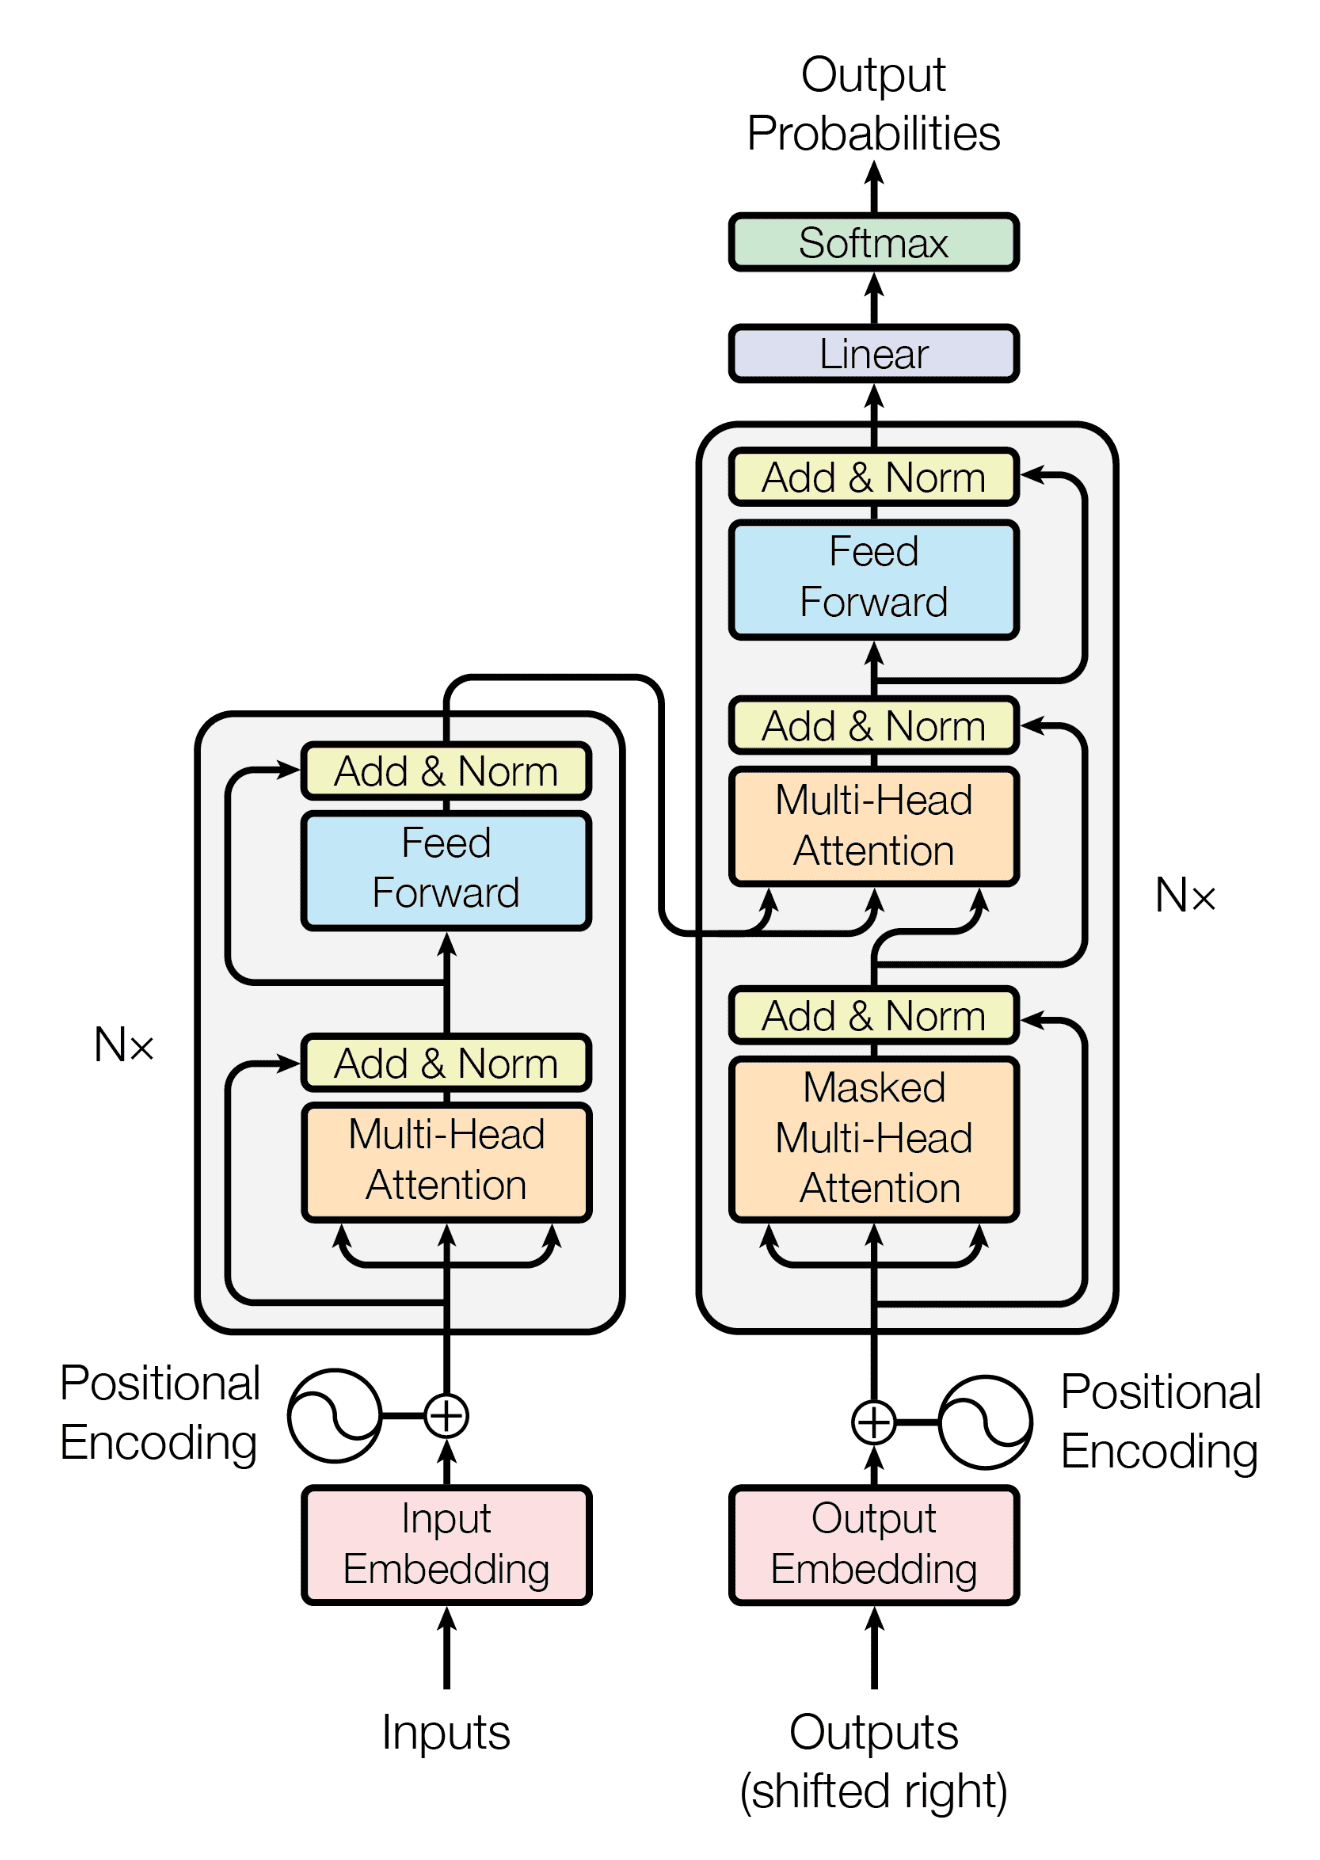

---
---
Will be creating the simple shakespearean text generator as the sample project

In [ ]:
# Firstly, let's import all the necessary packages needed.
import os
import numpy as np
import pandas as pd

import torch
import tensorflow as tf

%matplotlib inline

import matplotlib.pyplot as plt

In [ ]:
# Let's define global variables that will be used throughout the code
batch_dim = 8
vocab_dim = 10000
max_seq_len = 128
embedding_dim = 512
positional_denominator_coeff = 10000
attention_weights_dim = 64
num_self_attention_heads = embedding_dim // attention_weights_dim

## 2. Transformers
Transformer architecture was famously introduced in a research paper titled : 'Attention is all you need', however the underpinnings of it, i.e., the attention model was introduced earlier, it was the transformer model, that gave the attention mechanism a boost in performance and the huge burst of usecases and language models emerged from it. Transformer architecture is an auto-encoder architecture, and consists of an encoder and a decoder. Both encoder and decoder utilize self-attention mechanism and the decoder also utilizes cross-attention that takes in the encoder output and cross-attends to it while generating the decoded output. Let's define each component of the encoder and decoder using numpy, tensorflow and pytorch and ultimately the base transformer architecture, which we'll use to create and train a base model for shakespearean text generation and later modify the base architecture and build advanced architectures like Bert and GPT.

#### 2.1 The Encoder

Encoder, as defined above, takes in the input embeddings or lower dimensional representations of tokens, learns the correlation between the words in the input sequence and the impact of ordering of the words and generates a consolidated smaller dimensional representation of the input token embeddings called the encoded activation. Let's first define a very important concept of the encoder below, positional encoding.

##### 2.1.1 Positional Encodings

RNN or LSTM based encoders and decoders have an inherent temporal concept, in that they process each word in the sequence one after the other, thus keeping the order of words intact. Transformers on the other hand don't process words in order by default, this can lead to wrong patterns being learnt or unassociated words being grouped together. Thus to introduce the order of words and keep the sequence intact, positional encoding is introduced.

As described quite well in the [article](https://e2eml.school/transformers.html) by e2eml, it isn't feasible to give each word in the sentence an index to use as the positional encoding as the data would have a very high variance of lengths of sequences, and thus the model won't be able to generalize. Thus positional encoding is calculated as adding a rotational factor to the word embedding keeping the original word embedding at center and rotating by certain angle depending on the position of the word in the sequence. For example, from the image below

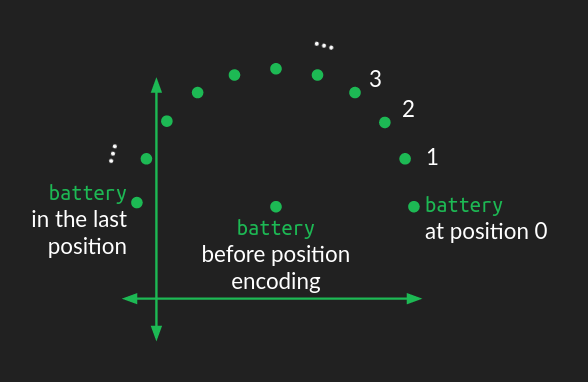

Fig : Image From e2eml for positional encoding.


If the word battery is at the initial position in the sequence, positional encoding will add an equivalent encoding with angle rotation A, resulting in the word embedding being represented at position 0, while for each later position, it will add encoding with angle variations to give different positions.

For mathematical description, see [here](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)

Positional encoding is calculated as, for a word at time step $t$, the encoding element for dimension $i$ (given embedding representation in $d$ dimensions) is given as

\begin{align}
\ p_t^i = \left\{
\begin{array}{cl}
sin(𝜔_k.t) & i = 2k\\
cos(𝜔_k.t) & i = 2k+1
\end{array}
\right.
\end{align}

the embedding dimensions are required to be divisible by 2, so for each word, the positional encoding can be thought of as a vector,

\begin{align}
  p_t &= \begin{bmatrix}
          sin(𝜔_1.t) \\
          cos(𝜔_1.t) \\
          sin(𝜔_2.t) \\
          cos(𝜔_2.t) \\
          \vdots \\
          sin(d/2.t) \\
          cos(d/2.t)
        \end{bmatrix}
\end{align}

where
\begin{align}
𝜔_k = \frac{1}{10000^{2k/d}}
\end{align}

so for example for a string of length 4,

with word embeddings e0, e1, e2, e3 with embedding dimension as 4

positional embeddings will be calculated as :

p0 = [sin(0/10000^(0/4)), cos(0/10000^(0/4)), sin(0/10000^(2/4)), cos(0/10000^(2/4))]

p1 = [sin(1/10000^(0/4)), cos(1/10000^(0/4)), sin(1/10000^(2/4)), cos(1/10000^(2/4))]

p2 = [sin(2/10000^(0/4)), cos(2/10000^(0/4)), sin(2/10000^(2/4)), cos(2/10000^(2/4))]

p3 = [sin(3/10000^(0/4)), cos(3/10000^(0/4)), sin(3/10000^(2/4)), cos(3/10000^(2/4))]

so positionally encoded word embeddings become :

\begin{align}
𝜑_t = 𝒘_t + p_t
\end{align}

In [ ]:
# Let's define the positional encoding
def positionally_encode(word_embedding):
    # Word embedding will be of shape (Batch_size, sequence_length, embedding_dimension)
    emb_dim = word_embedding.shape[-1]

    positions = np.arange(word_embedding.shape[1]).reshape((word_embedding.shape[1], 1))

    denom_idxs = np.arange(0, emb_dim, 2)

    denominator = np.ma.power([10000], [(i/emb_dim) for i in denom_idxs])

    even_idx_positions = np.sin(np.divide(positions, denominator))

    odd_idx_positions = np.cos(np.divide(positions, denominator))

    position_encoding = np.dstack((even_idx_positions, odd_idx_positions)).reshape((len(positions), -1))

    pos_embedded = np.add(word_embedding, position_encoding)

    return np.array(pos_embedded)

In [ ]:
a = np.random.randn(10, 6, 4)

In [ ]:
pos_encoded = positionally_encode(a)

Let's define this function as tensorflow and pytorch layers, so that we can use them in our models.

In [ ]:
# TensorFlow Positional Encoding Layer
class TF_POSITIONAL_ENCODER(tf.keras.layers.Layer):
  def __init__(self):
    super(TF_POSITIONAL_ENCODER, self).__init__()
    denominator_idxs = tf.range(0, embedding_dim, 2)
    denominator_factors = tf.math.divide(denominator_idxs, tf.constant(embedding_dim))
    self.denominator = tf.math.pow(positional_denominator_coeff, denominator_factors)

  def call(self, word_embedding):
    # Accepts embedding of shape : (Batch_size, Max_Sequence_length, Embedding_dimensions)
    word_embedding = tf.cast(word_embedding, tf.float64)

    num_positions = word_embedding.shape[1]

    positional_idxs = tf.expand_dims(tf.range(num_positions, dtype='float64'), -1)

    even_positions = tf.math.sin(tf.math.divide(positional_idxs, self.denominator))

    odd_positions = tf.math.cos(tf.math.divide(positional_idxs, self.denominator))

    positional_embedding = tf.reshape(tf.stack([even_positions, odd_positions], axis=2), (max_seq_len, embedding_dim))

    word_embedding = tf.add(word_embedding, positional_embedding)

    return word_embedding

In [ ]:
sample_input = np.random.randn(batch_dim, max_seq_len, embedding_dim)

In [ ]:
pe = TF_POSITIONAL_ENCODER()
a = tf.convert_to_tensor(sample_input)
tf_embedded = pe(a)

tf_embedded = tf_embedded.numpy()

In [ ]:
# PyTorch Positional Encoding Layer
class PT_POSITIONAL_ENCODER(torch.nn.Module):
  def __init__(self):
    super(PT_POSITIONAL_ENCODER, self).__init__()
    denominator_idxs = torch.arange(0, embedding_dim, 2)
    self.denominator = torch.pow(positional_denominator_coeff, denominator_idxs/embedding_dim)

  def forward(self, word_embedding):
    word_embedding = word_embedding.type(torch.float64)

    num_positions = word_embedding.shape[1]

    positional_idxs = torch.unsqueeze(torch.arange(num_positions, dtype=torch.float64), -1)

    even_positions = torch.sin(positional_idxs/self.denominator)
    odd_positions = torch.cos(positional_idxs/self.denominator)

    positional_embedding = torch.flatten(torch.stack([even_positions, odd_positions], dim=2), start_dim=1, end_dim=2)

    word_embedding = torch.add(word_embedding, positional_embedding)

    return word_embedding

In [ ]:
pe = PT_POSITIONAL_ENCODER()
a = torch.from_numpy(sample_input)
pt_embedded = pe(a)

pt_embedded = pt_embedded.numpy()

In [ ]:
tf_embedded[0][0][:10]

array([-1.21667242,  0.38050437,  0.72322512,  1.33098093,  0.59968609,
        1.53265923, -0.59865713,  1.23208992,  0.26041424,  0.55953535])

In [ ]:
pt_embedded[0][0][:10]

array([-1.21667238,  0.38050436,  0.72322512,  1.33098093,  0.59968609,
        1.53265925, -0.59865714,  1.23208992,  0.26041425,  0.55953536])

Let's start with self attention understanding and implementation

### Attention

Attention mechanism was introduced as a method of obtaining internal relations between the tokens and figure out which tokens contribute the most to the prediction token at time step t.

so for example in a text translation setting, suppose we've a sentence in english : "I love machine learning" and we want to translate it in hindi : "मुझे मशीन लर्निंग पसंद है".

Each token in the output predictions will depend not only the encoder final output, but input embedding tokens as well. So to give weightage to each token and find the contributions each token makes for prediction at a time step, attention is used.


```python
                    T0

Output Text        "मुझे" "मशीन" "लर्निंग" "पसंद" "है"
Output Embeddings  [...] [...]  [...]  [...]  [...]
                 ____|____________________________
                |           Attention             |
                |_________________________________|
                    |      |        |          |
                    |      |        |          |
Input Embeddings  [...]  [...]    [...]      [...]
Input Text         "I"   "love"  "machine"  "learning"



                          T1

Output Text        "मुझे" "मशीन" "लर्निंग" "पसंद" "है"
Output Embeddings  [...] [...]  [...]  [...]  [...]
                 __________|______________________
                |           Attention             |
                |_________________________________|
                    |      |        |          |
                    |      |        |          |
Input Embeddings  [...]  [...]    [...]      [...]
Input Text         "I"   "love"  "machine"  "learning"

                              ...
                              ...
                              ...

```

So as seen in the above image, to predict T0, all the input embeddings are fed to an attention block that calculates the importance of each token (based on learnt attention weights) and makes a prediction for T0.


Attention weights are learnt using a simple linear layer and then applying a softmax on top of it, so it applies softmax for each time step using activations from all the time steps in input.

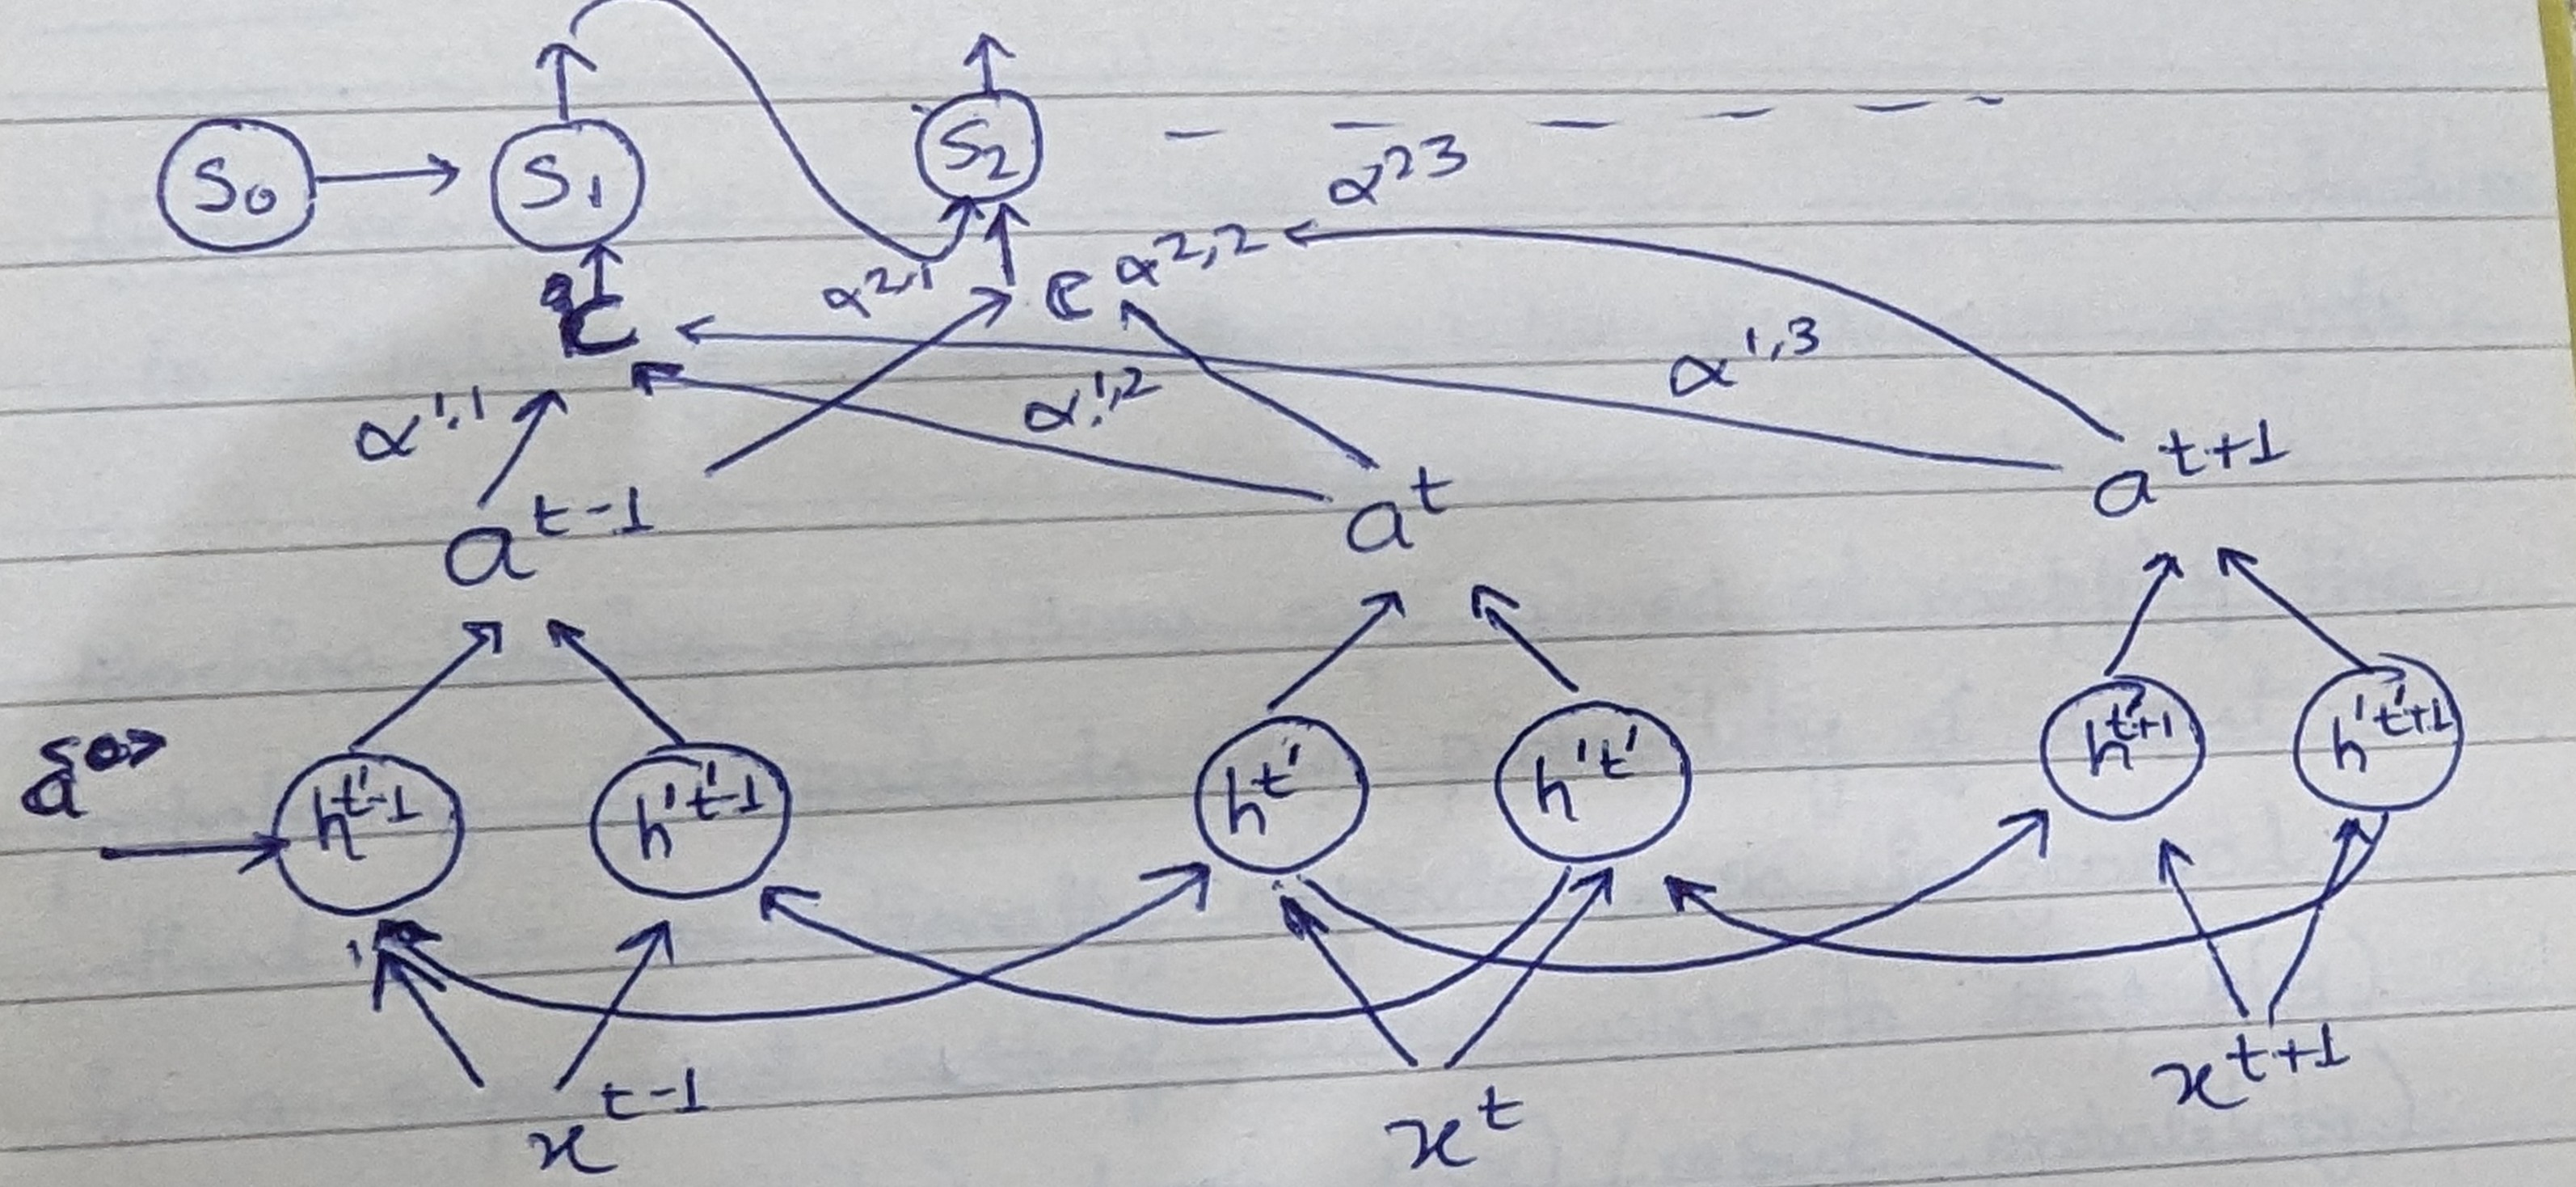



From above image, we can understand the flow of attention.

Here presented is a bi-directional LSTM or RNN.

xt represents input embedding at time step t

ht represents the tanh activated linear activation
h't represents the back path tanh activated linear activation

at is the weighted linear activation of forward path tanh activated input and backward path tanh activated input

at = wxht + wxh't

alpha t is the softmax activation of the linear activation of previous time step output activation and current at

alpha t = softmax(linear(st-1 + at))

c is the context vector and is calculated as
c = sum over t(alpha t . at)

---

### Self Attention

Attention finds the correlation between different time step positions of input embedding to the output embedding, while self attention finds the correlation between within the input embeddings.

It is anologous to searching a database, in that, we have a set of indexes that define some data stored in the database and we search the database using a query, the database then matches that query with indices and finds the index that matches the most with the input query, it then retrieves the data stored at that index and returns it's value.

Similar to this, the self-attention mechanism deploys three sets of learnable parameters Query, Key and Value.

An example of key matrix (numbers are repeated as i'm lazy)

<table>
  <tr>
    <td>
    </td>
    <td>
      Hi
    </td>
    <td>
      There
    </td>
    <td>
      How
    </td>
    <td>
      Are
    </td>
    <td>
      You
    </td>
  </tr>
  <tr>
    <td>
      Hi
    </td>
    <td>
      1.0
    </td>
    <td>
      0.25
    </td>
    <td>
      0.01
    </td>
    <td>
      0.36
    </td>
    <td>
      0.22
    </td>
  </tr>
  <tr>
    <td>
      There
    </td>
    <td>
      1.0
    </td>
    <td>
      0.25
    </td>
    <td>
      0.01
    </td>
    <td>
      0.36
    </td>
    <td>
      0.22
    </td>
  </tr>
  <tr>
    <td>
      How
    </td>
    <td>
      1.0
    </td>
    <td>
      0.25
    </td>
    <td>
      0.01
    </td>
    <td>
      0.36
    </td>
    <td>
      0.22
    </td>
  </tr>
  <tr>
    <td>
      Are
    </td>
    <td>
      1.0
    </td>
    <td>
      0.25
    </td>
    <td>
      0.01
    </td>
    <td>
      0.36
    </td>
    <td>
      0.22
    </td>
  </tr>
  <tr>
    <td>
      You
    </td>
    <td>
      1.0
    </td>
    <td>
      0.25
    </td>
    <td>
      0.01
    </td>
    <td>
      0.36
    </td>
    <td>
      0.22
    </td>
  </tr>
</table>

This table (in a way) represents the correlation between two tokens (it is obvious that the correlation between the same tokens would be the highest), but for other tokens, the correlation or weightage is learnt using multiple samples and the relation between those tokens in a sentence.

Continuing with the anology of the database, the query matrix represents the parameter space in which our input query can be transformed into to be in the same space that can be searched and matched with the keys. So to obtain the the representation of the query in the searchable space, we multiply the input with the query weights (done using a linear layer)

As we want to search for correlations within the same input embeddings only (self-attention), our key activation will be calculated in the same way, just with a different set of weights. Then to find the similar keys, we find the similarity using cosine similarity, which is

cosine(A, B) = (A.B)/|A||B|

Where |A||B| is scaling factor,

so this can be re-written as  :

similarity (A, B) = (A.B)/scaling

or for query and key

Similarity (Q, K) = Q.K^T/scaling

in the attention is all you need paper, the scaling parameter used was the dimention of the key vector.

so, similarity(Q, K) = Q.K^T/sqrt(d_k)

then we apply softmax on top of it to get how much importance each token has for other tokens.

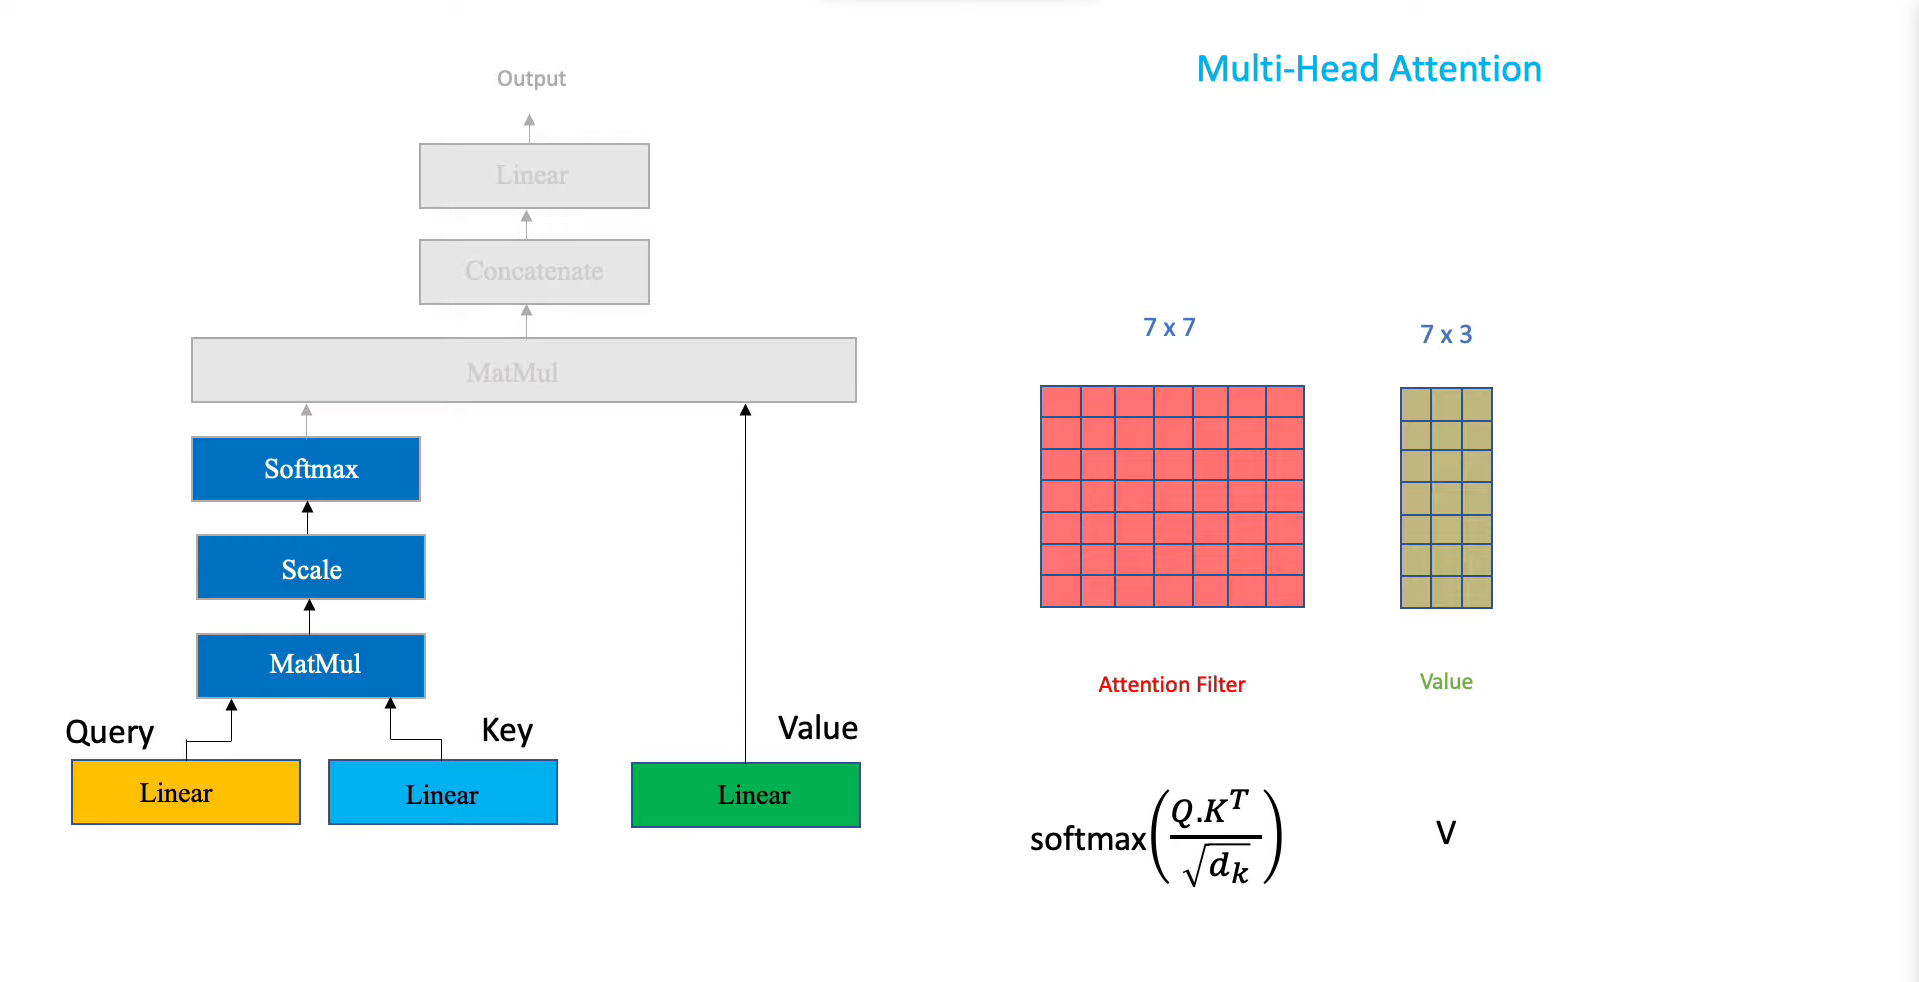

Let's implement self-attention head.

In [ ]:
def self_attention_head(input_embedding):
  # Input Embeddings will be of shape : (batch_size, max_seq_len, embedding_size)

  # Query, Key and Value weight matrices
  query_weight_matrix = np.random.randn(embedding_dim, attention_weights_dim).astype(np.float128)
  key_weight_matrix = np.random.randn(embedding_dim, attention_weights_dim).astype(np.float128)
  value_weight_matrix = np.random.randn(embedding_dim, attention_weights_dim).astype(np.float128)

  # Multiplying with query, key and value matrices to obtain query, key and value vectors
  query_activation = np.dot(input_embedding, query_weight_matrix)
  key_activation = np.dot(input_embedding, key_weight_matrix)
  value_activation = np.dot(input_embedding, value_weight_matrix)

  # Matrix Multiplication to obtain the similarity matrix
  qk = np.matmul(query_activation, np.transpose(key_activation, (0, 2, 1)))

  # Normalizing
  qk_norm = qk/np.sqrt(attention_weights_dim)

  # Applying Softmax
  softmaxed_qk = np.exp(qk_norm) / (np.sum(np.exp(qk_norm), axis=0) + 1e-6)

  # Matrix Multiplication with Value vector
  qkv = np.matmul(softmaxed_qk, value_activation)

  return qkv

In [ ]:
attention_applied = self_attention_head(sample_input)

The above is an implementation of one head of attention, to learn more linguistic features and relations between the texts, we can use multiple heads and concatenate them and then pass them through a linear layer to obtain the final encoder output.


Let's implement a very basic transformer encoder :

In [ ]:
def multi_head_attention(input_embedding):
  attention_activations = []
  for i in range(num_self_attention_heads):
    attention_activations.append(self_attention_head(input_embedding))

  multi_head_activation = np.concatenate(attention_activations, axis=-1)

  return multi_head_activation

In [ ]:
multi_head_activation = multi_head_attention(sample_input)

In [ ]:
def encoder(input_embedding):
    positionally_encoded = positionally_encode(input_embedding)

    multi_head_attention_outs = multi_head_attention(positionally_encoded)

    encoder_linear_layer = np.random.randn(embedding_dim, embedding_dim).astype(np.float128)

    encoded = np.dot(multi_head_attention_outs, encoder_linear_layer)

    return encoded

In [ ]:
encoded = encoder(sample_input)

So we implemented a very basic transformer encoder head with numpy and random weights, let's convert it into layers in pytorch and tensorflow for later use. (Note : Not implementing masking and other normalization best practices right now, will add down later)

In [ ]:
class TF_SELF_ATTENTION(tf.keras.layers.Layer):
    def __init__(self):
        super(TF_SELF_ATTENTION, self).__init__()

    def build(self, input_shape):
        # Input Shape is (Batch_size, max_seq_len, embedding_dim)

        # b -> batch dimension, m -> max seq len dimension, e -> embedding dimension, a -> attention weights dimension
        self.Q_w = tf.keras.layers.Dense(attention_weights_dim)
        self.K_w = tf.keras.layers.Dense(attention_weights_dim)
        self.V_w = tf.keras.layers.Dense(attention_weights_dim)

    def call(self, input_embedding):
        # Obtain Key, Query and Value Vectors
        q_v = self.Q_w(input_embedding)
        k_v = self.K_w(input_embedding)
        v_v = self.V_w(input_embedding)

        # Multiply Query and Key vectors
        qk = tf.matmul(q_v, k_v, transpose_b=True)

        # Normalize
        qk_norm = tf.divide(qk, float(np.sqrt(attention_weights_dim)))

        # Find softmax weights
        softmaxed = tf.nn.softmax(qk_norm, axis=-1)

        # Multiply value vector to obtain final results
        qkv = tf.matmul(softmaxed, v_v)

        return qkv


In [ ]:
input_tensor = tf.convert_to_tensor(sample_input)
attention_layer = TF_SELF_ATTENTION()
tf_attention_applied = attention_layer(input_tensor)
layer_out = tf_attention_applied.numpy()

In [ ]:
layer_out.shape

(8, 128, 64)

In [ ]:
attention_applied.shape

(8, 128, 64)

In [ ]:
layer_out[0][0][:10]

array([-1.7726088e-01, -8.4624402e-02, -2.6972488e-01,  7.7178156e-05,
        4.5135655e-02, -4.9841139e-03,  2.6414741e-03, -6.2750465e-01,
        2.5251046e-01,  7.6041025e-01], dtype=float32)

In [ ]:
attention_applied[0][0][:10]

array([  83.99194027,  -58.37571691,   69.94588181, -101.06811753,
       -168.50560218,   70.08717358,   52.59440542,   65.40004892,
       -111.69295198,   -4.33886161], dtype=float128)

Rather than going with the above method, let's use matrix multiplications for faster processing for multiple heads.

In [ ]:
class TF_MULTI_HEAD_SELF_ATTENTION(tf.keras.layers.Layer):
    def __init__(self, num_heads=num_self_attention_heads):
        super(TF_MULTI_HEAD_SELF_ATTENTION, self).__init__()

    def build(self, input_shape):
        # b -> batch dimension, h -> num_attention_heads, m -> max seq len dimension, e -> embedding dimension, a -> attention weights dimension
        self.Q_w = tf.keras.layers.Dense(attention_weights_dim)
        self.K_w = tf.keras.layers.Dense(attention_weights_dim)
        self.V_w = tf.keras.layers.Dense(attention_weights_dim)

    def call(self, input_embedding):
        # Input Shape is (Batch_size, max_seq_len, embedding_dim)
        # Repeating it for number of heads
        # Shape : (Batch_size, 1, max_seq_len, embedding_dim)
        input_embedding_extended = tf.expand_dims(input_embedding, axis=1)
        # Repeat to serve as input for multiple heads
        # Shape : (Batch_size, num_heads, max_seq_len, embedding_dim)
        input_embedding_heads = tf.repeat(input_embedding_extended, repeats=num_self_attention_heads, axis=1)

        # Obtain Key, Query and Value Vectors
        q_v = self.Q_w(input_embedding_heads)
        k_v = self.K_w(input_embedding_heads)
        v_v = self.V_w(input_embedding_heads)

        # Output shapes : (Batch_dim, num_heads, max_seq_len, attention_weights_dim)

        # Multiply Query and Key vectors
        qk = tf.matmul(q_v, k_v, transpose_b=True)

        # Normalize
        qk_norm = tf.divide(qk, float(np.sqrt(attention_weights_dim)))

        # Find softmax weights
        softmaxed = tf.nn.softmax(qk_norm, axis=-1)

        # Multiply value vector to obtain final results
        qkv = tf.matmul(softmaxed, v_v)

        return qkv

In [ ]:
input_tensor_multi_head = tf.convert_to_tensor(sample_input)
attention_layer = TF_MULTI_HEAD_SELF_ATTENTION()
tf_attention_applied_multi = attention_layer(input_tensor_multi_head)
layer_out_multi_head = tf_attention_applied_multi.numpy()

In [ ]:
layer_out_multi_head[0]

array([[[ 5.16188920e-01, -1.27039582e-01, -3.45757037e-01, ...,
          2.46279269e-01,  1.39185101e-01, -5.56251049e-01],
        [-1.82498083e-01,  2.85011470e-01,  6.73449337e-01, ...,
         -1.18879676e-01,  2.93861836e-01, -1.93606466e-01],
        [ 1.02454674e+00, -3.59746220e-04,  3.27515118e-02, ...,
         -2.38843575e-01,  2.87889689e-01, -7.75745511e-01],
        ...,
        [-2.81135201e-01,  2.08198056e-01,  5.01098394e-01, ...,
         -2.33674899e-01, -7.35766351e-01, -3.06267530e-01],
        [-2.28247449e-01,  1.69605896e-01, -1.22790284e-01, ...,
          6.03135638e-02,  5.89571416e-01,  3.93145263e-01],
        [ 9.81985152e-01, -1.93622336e-01,  1.98044196e-01, ...,
         -8.00485671e-01, -3.75559121e-01, -5.11579156e-01]],

       [[ 5.16188920e-01, -1.27039582e-01, -3.45757037e-01, ...,
          2.46279269e-01,  1.39185101e-01, -5.56251049e-01],
        [-1.82498083e-01,  2.85011470e-01,  6.73449337e-01, ...,
         -1.18879676e-01,  2.93861836e

One issue with the above implementation is, it applies the same weights to all heads, thus it is incorrect, so will have to create multiple layers and then concatenate. The below is the correct implementation.

In [ ]:
class TF_MULTI_HEAD_SELF_ATTENTION(tf.keras.layers.Layer):
    def __init__(self, num_heads=num_self_attention_heads):
        super(TF_MULTI_HEAD_SELF_ATTENTION, self).__init__()
        # b -> batch dimension, h -> num_attention_heads, m -> max seq len dimension, e -> embedding dimension, a -> attention weights dimension
        self.attention_heads = [TF_SELF_ATTENTION() for _ in range(num_self_attention_heads)]

    def __call__(self, input_embedding):
        # Input Shape is (Batch_size, max_seq_len, embedding_dim)
        # Repeating it for number of heads
        head_outs = []

        for i in range(num_self_attention_heads):
            attention_outs = self.attention_heads[i](input_embedding)
            head_outs.append(attention_outs)

        outputs = tf.concat(head_outs, axis=-1)

        return outputs



In [ ]:
input_tensor_multi_head = tf.convert_to_tensor(sample_input)
attention_layer = TF_MULTI_HEAD_SELF_ATTENTION()
tf_attention_applied_multi = attention_layer(input_tensor_multi_head)
layer_out_multi_head = tf_attention_applied_multi.numpy()

In [ ]:
layer_out_multi_head[0]

array([[-0.23058127, -0.6180205 , -0.5464721 , ...,  0.18853374,
         0.34637147, -0.7007926 ],
       [-0.37050343,  0.04647605, -0.24382499, ...,  0.18468319,
         0.18443274, -0.50988626],
       [ 0.07159404,  0.10458548, -0.34824303, ...,  0.148996  ,
        -0.2237228 , -0.28485027],
       ...,
       [-0.0497643 , -0.25927806,  0.11905076, ..., -0.64915097,
         0.34381184, -0.53898424],
       [-0.59297675, -0.5703047 , -0.33593735, ..., -0.47061893,
         0.09153632, -0.60017264],
       [-0.81191415, -0.13565443,  0.1196061 , ..., -0.306244  ,
         0.07172399,  0.08405655]], dtype=float32)

In [ ]:
layer_out_multi_head.shape

(8, 128, 512)

So from the above implementation, all the weights are different thus making sense to use multiple heads. Let's put this all together in an encoder block.

In [ ]:
class TF_TRANSFORMER_ENCODER(tf.keras.layers.Layer):
    def __init__(self):
        super(TF_TRANSFORMER_ENCODER, self).__init__()
        self.positional_encoder = TF_POSITIONAL_ENCODER()
        self.multi_head_encoder = TF_MULTI_HEAD_SELF_ATTENTION()
        self.linear_activation = tf.keras.layers.Dense(embedding_dim)


    def call(self, input_embedding):
        # Positionally Encode
        positional_encoded = self.positional_encoder(input_embedding)

        # Calculate Multi-Head Activations
        attention_head_activated = self.multi_head_encoder(positional_encoded)

        # Add and Normalize
        add_normalized = tf.keras.layers.Add()([positional_encoded, attention_head_activated])
        add_normalized = tf.keras.layers.LayerNormalization()(add_normalized)

        #Linear Activation (Output Layer)
        linear_activation = self.linear_activation(add_normalized)

        # Add and Normalize
        output = tf.keras.layers.Add()([linear_activation, add_normalized])
        output = tf.keras.layers.LayerNormalization()(output)

        return output

In [ ]:
input_tensor_encoder = tf.convert_to_tensor(sample_input)
encoder = TF_TRANSFORMER_ENCODER()
encoded = encoder(input_tensor_multi_head)
encoded = encoded.numpy()

In [ ]:
encoded[0]

array([[-0.570344  , -2.095883  , -0.97280735, ...,  1.2983872 ,
        -0.00469776, -1.541843  ],
       [ 0.6090017 , -1.0572128 ,  0.9819478 , ...,  0.31301942,
         1.1539212 , -0.26481023],
       [ 1.1888982 , -0.5789339 , -0.00299943, ...,  0.7112174 ,
        -0.4776791 ,  0.12639084],
       ...,
       [ 1.5371944 ,  0.61685133,  0.14177728, ..., -0.8972383 ,
        -0.35508573,  0.35542282],
       [ 0.1680909 , -0.28052342,  1.2894484 , ..., -0.3765119 ,
         0.5471839 , -1.1797279 ],
       [ 1.8600734 , -0.05107542, -1.4410866 , ..., -0.98080426,
         0.89193493, -1.1528214 ]], dtype=float32)

And now in pytorch

In [ ]:
class PT_SELF_ATTENTION(torch.nn.Module):
    def __init__(self):
        super(PT_SELF_ATTENTION, self).__init__()

        # Input Shape is (Batch_size, max_seq_len, embedding_dim)
        # b -> batch dimension, m -> max seq len dimension, e -> embedding dimension, a -> attention weights dimension
        self.Q_w = torch.nn.Linear(embedding_dim, attention_weights_dim)
        self.K_w = torch.nn.Linear(embedding_dim, attention_weights_dim)
        self.V_w = torch.nn.Linear(embedding_dim, attention_weights_dim)

    def forward(self, input_embedding):
        # Obtain Key, Query and Value Vectors
        q_v = self.Q_w(input_embedding)
        k_v = self.K_w(input_embedding)
        v_v = self.V_w(input_embedding)

        # Multiply Query and Key vectors
        k_T = torch.transpose(k_v, -2, -1)
        qk = torch.bmm(q_v, k_T)

        # Normalize
        qk_norm = torch.div(qk, float(np.sqrt(attention_weights_dim)))

        # Find softmax weights
        softmaxed = torch.nn.functional.softmax(qk_norm, -1)

        # Multiply value vector to obtain final results
        qkv = torch.bmm(softmaxed, v_v)

        return qkv

In [ ]:
torch_input = torch.from_numpy(sample_input).type(torch.float32)
attention_module = PT_SELF_ATTENTION()
attention_activated = attention_module(torch_input)
attention_activated = attention_activated.detach().numpy()

In [ ]:
attention_activated[0]

array([[ 0.04743899,  0.01400542, -0.03557509, ...,  0.08703537,
         0.04806585,  0.00980387],
       [ 0.0517636 , -0.00133879, -0.00307746, ...,  0.10331643,
         0.01276864,  0.08874835],
       [ 0.00592674,  0.03034555,  0.00153565, ...,  0.10177414,
         0.01968831,  0.08656306],
       ...,
       [ 0.01125748, -0.01106206, -0.01112248, ...,  0.07141116,
         0.00652626,  0.08914953],
       [ 0.07293255, -0.04741066, -0.02543055, ...,  0.06787437,
         0.062128  ,  0.05767725],
       [ 0.07151257, -0.01935143, -0.00336592, ...,  0.07727869,
         0.05212896,  0.06255747]], dtype=float32)

In [ ]:
attention_activated.shape

(8, 128, 64)

In [ ]:
class PT_MULTI_HEAD_SELF_ATTENTION(torch.nn.Module):
    def __init__(self):
        self.attention_heads = [PT_SELF_ATTENTION() for _ in range(num_self_attention_heads)]

    def __call__(self, input_embedding):
        # Input Shape is (Batch_size, max_seq_len, embedding_dim)
        # Repeating it for number of heads
        head_outs = []

        for i in range(num_self_attention_heads):
            attention_outs = self.attention_heads[i](input_embedding)
            head_outs.append(attention_outs)

        outputs = torch.concat(head_outs, -1)

        return outputs

In [ ]:
torch_input = torch.from_numpy(sample_input).type(torch.float32)
attention_module = PT_MULTI_HEAD_SELF_ATTENTION()
attention_activated = attention_module(torch_input)
attention_activated = attention_activated.detach().numpy()
attention_activated.shape

(8, 128, 512)

In [ ]:
attention_activated[0]

array([[-0.00635439, -0.03045298, -0.12539878, ..., -0.00281321,
        -0.03513192,  0.03033366],
       [ 0.0311615 , -0.04706116, -0.10895263, ..., -0.0633022 ,
        -0.00645581,  0.04797192],
       [ 0.08177728, -0.04841118, -0.14407593, ..., -0.00481299,
         0.01567376,  0.01844648],
       ...,
       [ 0.01946443,  0.00048377, -0.14605936, ...,  0.01651061,
         0.03933501,  0.01118923],
       [ 0.00607939, -0.03097057, -0.10279665, ..., -0.02549829,
        -0.02667998,  0.02793936],
       [ 0.05316945, -0.03361167, -0.13929789, ...,  0.01354776,
        -0.00261828,  0.04288559]], dtype=float32)

In [ ]:
class PT_TRANSFORMER_ENCODER(torch.nn.Module):
    def __init__(self):
        super(PT_TRANSFORMER_ENCODER, self).__init__()
        self.positional_encoder = PT_POSITIONAL_ENCODER()
        self.multi_head_encoder = PT_MULTI_HEAD_SELF_ATTENTION()
        self.linear_activation = torch.nn.Linear(embedding_dim, embedding_dim)


    def call(self, input_embedding):
        # Positionally Encode
        positional_encoded = self.positional_encoder(input_embedding)

        # Calculate Multi-Head Activations
        attention_head_activated = self.multi_head_encoder(positional_encoded)

        # Add and Normalize
        add_normalized = torch.add(positional_encoded, attention_head_activated)
        add_normalized = torch.nn.LayerNorm(embedding_dim)(add_normalized)

        #Linear Activation (Output Layer)
        linear_activation = self.linear_activation(add_normalized)

        # Add and Normalize
        output = torch.add(linear_activation, add_normalized)
        output = torch.nn.LayerNorm(embedding_dim)(output)

        return output

In [ ]:
torch_input = torch.from_numpy(sample_input).type(torch.float32)
encoder = PT_TRANSFORMER_ENCODER()
encoded = attention_module(torch_input)
encoded = encoded.detach().numpy()
encoded.shape

(8, 128, 512)

We've successfully implemented Encoder Block of the transformer architecture. We implemented self attention, multi-head self attention and the encoder.

The next and final part of a language model is the decoder. The decoder only has 1 slightly different component that we need to develop, that is masked self-attention.

Let's understand and implement the decoder as well of the transformer architecture first from scratch, then in both tensorflow as well as pytorch so that we can build more complex architectures based on transformer architecture like BERT, ROBERTA etc., and possibly the GPT architecture as well.



#### 2.1 The Decoder

Let's define the slightly different component of the decoder, the masked attention block.

##### 2.1.1 Masked Attention

Masked attention is just attention with the input masked, making some input tokens unavailable. This is mostly done at training time, where we mask all the next tokens and only consider the previously occured tokens to predict the next token, we then unmask the next token to calculate the loss. This way the model learns to predict the next word while keeping the context of the already generated (desired) tokens as well as the input.

In [ ]:
def masked_self_attention(input_embedding, mask=None):
    # Input Embeddings will be of shape : (batch_size, max_seq_len, embedding_size)

    # Query, Key and Value weight matrices
    query_weight_matrix = np.random.randn(embedding_dim, attention_weights_dim).astype(np.float128)
    key_weight_matrix = np.random.randn(embedding_dim, attention_weights_dim).astype(np.float128)
    value_weight_matrix = np.random.randn(embedding_dim, attention_weights_dim).astype(np.float128)

    # Multiplying with query, key and value matrices to obtain query, key and value vectors
    query_activation = np.dot(input_embedding, query_weight_matrix)
    key_activation = np.dot(input_embedding, key_weight_matrix)
    value_activation = np.dot(input_embedding, value_weight_matrix)

    # Matrix Multiplication to obtain the similarity matrix
    qk = np.matmul(query_activation, np.transpose(key_activation, (0, 2, 1)))

    # Normalizing
    qk_norm = qk/np.sqrt(attention_weights_dim)

    # This is the only difference, the masking code
    if mask:
        qk_norm += (1. - mask) *(-1e9)

    # Applying Softmax
    softmaxed_qk = np.exp(qk_norm) / (np.sum(np.exp(qk_norm), axis=0) + 1e-6)

    # Matrix Multiplication with Value vector
    qkv = np.matmul(softmaxed_qk, value_activation)

    return qkv

As seen from the above code, it's the same as the normal self attention, just adding a mask addition to mask the input creates the masked attention.

###### What does masking do??

The masking deployed in the decoder of the transformer architecture is called look-ahead masking. It prevents the model from paying attention to the next tokens (or look ahead).

The mask is simply an upper triangular matrix of shape (sequence_length, sequence_length) with each row and column representing if attention is to be applied at that time step to that token.

By turning every component to zero on the upper triangle, multiplying it with the Q and K, it'll only activate for entries not zero, thus only activating for next tokens.

```          
             <start>  w1    w2    <end>
             _________________________
<start>     |  1   |  0  |  0  |  0   |  
            |______|_____|_____|______|                   
  w1        |  1   |  1  |  0  |  0   |
            |______|_____|_____|______|
  w2        |  1   |  1  |  1  |  0   |
            |______|_____|_____|______|    
<end>       |  1   |  1  |  1  |  1   |
            |______|_____|_____|______|

```

Let's just modify our self attention modules defined above to handle masking as well.


Modified Self Attention Modules :

In [ ]:
class TF_SELF_ATTENTION(tf.keras.layers.Layer):
    def __init__(self):
        super(TF_SELF_ATTENTION, self).__init__()

    def build(self, input_shape):
        # Input Shape is (Batch_size, max_seq_len, embedding_dim)

        # b -> batch dimension, m -> max seq len dimension, e -> embedding dimension, a -> attention weights dimension
        self.Q_w = tf.keras.layers.Dense(attention_weights_dim)
        self.K_w = tf.keras.layers.Dense(attention_weights_dim)
        self.V_w = tf.keras.layers.Dense(attention_weights_dim)

    def call(self, input_embedding, mask=None):
        # Obtain Key, Query and Value Vectors
        q_v = self.Q_w(input_embedding)
        k_v = self.K_w(input_embedding)
        v_v = self.V_w(input_embedding)

        # Multiply Query and Key vectors
        qk = tf.matmul(q_v, k_v, transpose_b=True)

        # Normalize
        qk_norm = tf.divide(qk, float(np.sqrt(attention_weights_dim)))

        # Masking If Needed
        if mask:
            qk_norm += (1. - mask) *(-1e9)

        # Find softmax weights
        softmaxed = tf.nn.softmax(qk_norm, axis=-1)

        # Multiply value vector to obtain final results
        qkv = tf.matmul(softmaxed, v_v)

        return qkv

In [ ]:
class PT_SELF_ATTENTION(torch.nn.Module):
    def __init__(self):
        super(PT_SELF_ATTENTION, self).__init__()

        # Input Shape is (Batch_size, max_seq_len, embedding_dim)
        # b -> batch dimension, m -> max seq len dimension, e -> embedding dimension, a -> attention weights dimension
        self.Q_w = torch.nn.Linear(embedding_dim, attention_weights_dim)
        self.K_w = torch.nn.Linear(embedding_dim, attention_weights_dim)
        self.V_w = torch.nn.Linear(embedding_dim, attention_weights_dim)

    def forward(self, input_embedding, mask=None):
        # Obtain Key, Query and Value Vectors
        q_v = self.Q_w(input_embedding)
        k_v = self.K_w(input_embedding)
        v_v = self.V_w(input_embedding)

        # Multiply Query and Key vectors
        k_T = torch.transpose(k_v, -2, -1)
        qk = torch.bmm(q_v, k_T)

        # Normalize
        qk_norm = torch.div(qk, float(np.sqrt(attention_weights_dim)))

        # Masking
        if mask:
            qk_norm += (1. - mask) *(-1e9)

        # Find softmax weights
        softmaxed = torch.nn.functional.softmax(qk_norm, -1)

        # Multiply value vector to obtain final results
        qkv = torch.bmm(softmaxed, v_v)

        return qkv

One more adjustment required to the attention block is, as it can be seen from the decoder architecture here :
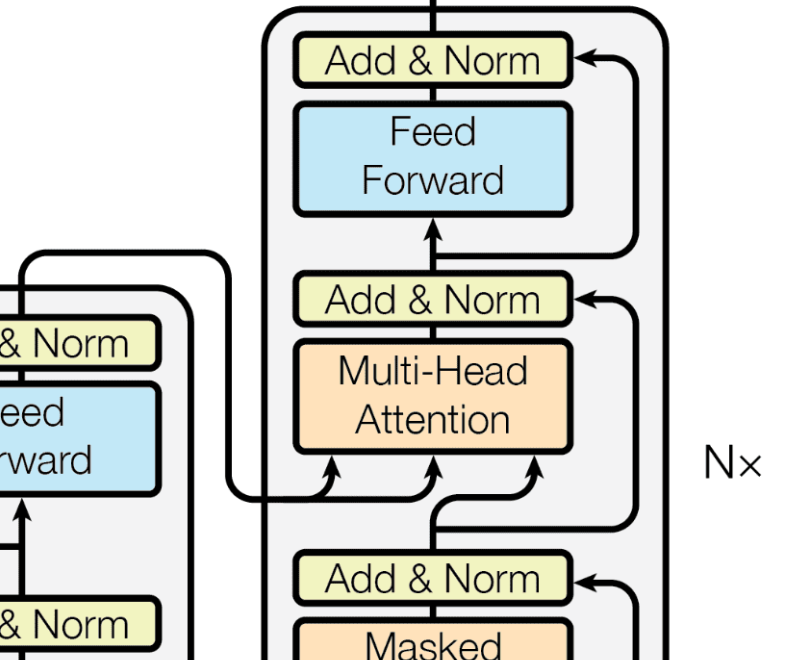

The query and key inputs to the multi-head attention block of the decoder are the outputs of the encoder, so we don't really need to calculate the query and key activations, rather use the input from encoder to calculate the value activations, so we can allow for our attention block to recieve query and key or we can break it into two separate classes, one that finds the query and key (or accept) and one that calculates the attention activation using the passed query, key and value.

Let's modify the classes accordingly

In [ ]:
# function to calculate Attention Activation :
def tf_self_attention(query, key, value, mask=None):
    # Mutliply the query and key activations
    qk = tf.matmul(query, key, transpose_b=True)

    # Normalize
    qk_norm = tf.divide(qk, float(np.sqrt(attention_weights_dim)))

    # Masking If Needed
    if mask:
        qk_norm += (1. - mask) *(-1e9)

    # Find softmax weights
    softmaxed = tf.nn.softmax(qk_norm, axis=-1)

    # Multiply value vector to obtain final results
    qkv = tf.matmul(softmaxed, value)

    return qkv


# Self attention class calls the block
class TF_SELF_ATTENTION(tf.keras.layers.Layer):
    def __init__(self):
        super(TF_SELF_ATTENTION, self).__init__()

    def build(self, input_shape):
        # Input Shape is (Batch_size, max_seq_len, embedding_dim)

        # b -> batch dimension, m -> max seq len dimension, e -> embedding dimension, a -> attention weights dimension
        self.Q_w = tf.keras.layers.Dense(attention_weights_dim)
        self.K_w = tf.keras.layers.Dense(attention_weights_dim)
        self.V_w = tf.keras.layers.Dense(attention_weights_dim)

    def call(self, query, key, value, mask=None):
        # Obtain Key, Query and Value Vectors
        q_v = self.Q_w(query)
        k_v = self.K_w(key)
        v_v = self.V_w(value)

        output = tf_self_attention(q_v, k_v, v_v, mask)

        return output

In [ ]:
# Similarily for pytorch
def pt_self_attention(query, key, value, mask=None):
    # Multiply Query and Key vectors
    k_T = torch.transpose(key, -2, -1)
    qk = torch.bmm(query, k_T)

    # Normalize
    qk_norm = torch.div(qk, float(np.sqrt(attention_weights_dim)))

    # Masking
    if mask:
        qk_norm += (1. - mask) *(-1e9)

    # Find softmax weights
    softmaxed = torch.nn.functional.softmax(qk_norm, -1)

    # Multiply value vector to obtain final results
    qkv = torch.bmm(softmaxed, value)

    return qkv



class PT_SELF_ATTENTION(torch.nn.Module):
    def __init__(self):
        super(PT_SELF_ATTENTION, self).__init__()

        # Input Shape is (Batch_size, max_seq_len, embedding_dim)
        # b -> batch dimension, m -> max seq len dimension, e -> embedding dimension, a -> attention weights dimension
        self.Q_w = torch.nn.Linear(embedding_dim, attention_weights_dim)
        self.K_w = torch.nn.Linear(embedding_dim, attention_weights_dim)
        self.V_w = torch.nn.Linear(embedding_dim, attention_weights_dim)

    def forward(self, query, key, value, mask=None):
        # Obtain Key, Query and Value Vectors
        q_v = self.Q_w(query)
        k_v = self.K_w(key)
        v_v = self.V_w(value)

        output = pt_self_attention(q_v, k_v, v_v, mask)

        return output

With the above changes, we've to make changes to our multi-head attention layers as well as our encoder. Let's do this next.

In [ ]:
class TF_MULTI_HEAD_SELF_ATTENTION(tf.keras.layers.Layer):
    def __init__(self, num_heads=num_self_attention_heads):
        super(TF_MULTI_HEAD_SELF_ATTENTION, self).__init__()
        # b -> batch dimension, h -> num_attention_heads, m -> max seq len dimension, e -> embedding dimension, a -> attention weights dimension
        self.attention_heads = [TF_SELF_ATTENTION() for _ in range(num_self_attention_heads)]

    def __call__(self, query, key, value, mask=None):
        # Input Shape is (Batch_size, max_seq_len, embedding_dim)
        # Repeating it for number of heads
        head_outs = []

        for i in range(num_self_attention_heads):
            attention_outs = self.attention_heads[i](query, key, value, mask)
            head_outs.append(attention_outs)

        outputs = tf.concat(head_outs, axis=-1)

        return outputs


# PyTorch multi-headed attention block
class PT_MULTI_HEAD_SELF_ATTENTION(torch.nn.Module):
    def __init__(self):
        self.attention_heads = [PT_SELF_ATTENTION() for _ in range(num_self_attention_heads)]

    def __call__(self, query, key, value, mask=None):
        # Input Shape is (Batch_size, max_seq_len, embedding_dim)
        # Repeating it for number of heads
        head_outs = []

        for i in range(num_self_attention_heads):
            attention_outs = self.attention_heads[i](query, key, value, mask)
            head_outs.append(attention_outs)

        outputs = torch.concat(head_outs, -1)

        return outputs

In [ ]:
# Finaly the modified encoder architectures
class TF_TRANSFORMER_ENCODER(tf.keras.layers.Layer):
    def __init__(self):
        super(TF_TRANSFORMER_ENCODER, self).__init__()
        self.positional_encoder = TF_POSITIONAL_ENCODER()
        self.multi_head_encoder = TF_MULTI_HEAD_SELF_ATTENTION()
        self.linear_activation = tf.keras.layers.Dense(embedding_dim)


    def call(self, input_embedding):
        # Positionally Encode
        positional_encoded = self.positional_encoder(input_embedding)

        # Calculate Multi-Head Activations
        attention_head_activated = self.multi_head_encoder(positional_encoded, positional_encoded, positional_encoded)

        # Add and Normalize
        add_normalized = tf.keras.layers.Add()([positional_encoded, attention_head_activated])
        add_normalized = tf.keras.layers.LayerNormalization()(add_normalized)

        #Linear Activation (Output Layer)
        linear_activation = self.linear_activation(add_normalized)

        # Add and Normalize
        output = tf.keras.layers.Add()([linear_activation, add_normalized])
        output = tf.keras.layers.LayerNormalization()(output)

        return output


    # Pytorch encoder
    class PT_TRANSFORMER_ENCODER(torch.nn.Module):
        def __init__(self):
            super(PT_TRANSFORMER_ENCODER, self).__init__()
            self.positional_encoder = PT_POSITIONAL_ENCODER()
            self.multi_head_encoder = PT_MULTI_HEAD_SELF_ATTENTION()
            self.linear_activation = torch.nn.Linear(embedding_dim, embedding_dim)


        def call(self, input_embedding):
            # Positionally Encode
            positional_encoded = self.positional_encoder(input_embedding)

            # Calculate Multi-Head Activations
            attention_head_activated = self.multi_head_encoder(positional_encoded, positional_encoded, positional_encoded)

            # Add and Normalize
            add_normalized = torch.add(positional_encoded, attention_head_activated)
            add_normalized = torch.nn.LayerNorm(embedding_dim)(add_normalized)

            #Linear Activation (Output Layer)
            linear_activation = self.linear_activation(add_normalized)

            # Add and Normalize
            output = torch.add(linear_activation, add_normalized)
            output = torch.nn.LayerNorm(embedding_dim)(output)

            return output

Let's test once again with the changes


In [ ]:
input_tensor_encoder = tf.convert_to_tensor(sample_input)
encoder = TF_TRANSFORMER_ENCODER()
encoded = encoder(input_tensor_multi_head)
encoded = encoded.numpy()
encoded.shape

(8, 128, 512)

In [ ]:
torch_input = torch.from_numpy(sample_input).type(torch.float32)
encoder = PT_TRANSFORMER_ENCODER()
encoded = attention_module(torch_input)
encoded = encoded.detach().numpy()
encoded.shape

(8, 128, 512)

Now that we've defined masked attention with capability to take in query key and values, the only component that is required for decoder is creation of the mask for masked attention. Let's define the mask generation. The mask that we drew above, can be obtained using the following code :

In [ ]:
def tf_create_lookahead_mask():
    mask = tf.linalg.band_part(tf.ones((1, max_seq_len, max_seq_len)), -1, 0)
    return mask

In [ ]:
def pt_create_lookahead_mask():
    mask = torch.tril(torch.ones(1, max_seq_len, max_seq_len))
    return mask

In [ ]:
tf_create_lookahead_mask()

<tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

In [ ]:
pt_create_lookahead_mask()

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

Now that we've everything we need to move forward, Let's now define the decoder architecture.



In [ ]:
class TF_TRANSFORMER_DECODER(tf.keras.layers.Layer):
    def __init__(self):
        self.position_encoder = TF_POSITIONAL_ENCODER()
        self.masked_attention_head = TF_MULTI_HEAD_SELF_ATTENTION()

        self.cross_attention_head = TF_MULTI_HEAD_SELF_ATTENTION()

        self.feedforward = tf.keras.layers.Dense(embedding_dim)

        self.output_layer = tf.keras.layers.Dense(vocab_dim, activation='softmax')


    def call(self, output_embeddings, encoded_input, mask=None):
        positionally_encoded = self.positional_encoder(output_embeddings)

        mask = tf_create_lookahead_mask()

        masked_attention_activated = self.masked_attention_head(positionally_encoded, positionally_encoded, positionally_encoded, mask=mask)

        add_normalized = tf.keras.layers.Add()([positionally_encoded, masked_attention_activated])
        add_normalized = tf.keras.layers.LayerNormalization()(add_normalized)

        cross_attention_activated = self.cross_attention_head(encoded_input, encoded_input, add_normalized)

        add_normalized = tf.keras.layers.Add()([add_normalized, cross_attention_activated])
        add_normalized = tf.keras.layers.LayerNormalization()(add_normalized)

        linear_activated = self.feedforward(add_normalized)

        add_normalized = tf.keras.layers.Add()([add_normalized, linear_activated])
        add_normalized = tf.keras.layers.LayerNormalization()(add_normalized)

        output = self.output_layer(add_normalized)

        return output

In [ ]:
class PT_TRANSFORMER_DECODER(torch.nn.Module):
    def __init__(self):
        self.position_encoder = PT_POSITIONAL_ENCODER()
        self.masked_attention_head = PT_MULTI_HEAD_SELF_ATTENTION()

        self.cross_attention_head = PT_MULTI_HEAD_SELF_ATTENTION()

        self.feedforward = torch.nn.Linear(embedding_dim, embedding_dim)

        self.output_layer = torch.nn.Linear(embedding_dim, vocab_dim)

    def call(self, output_embeddings, encoded_input):
        positionally_encoded = self.positional_encoder(output_embeddings)

        mask = pt_create_lookahead_mask()

        masked_attention_activated = self.masked_attention_head(positionally_encoded, positionally_encoded, positionally_encoded, mask=mask)

        add_normalized = torch.add(positionally_encoded, masked_attention_activated)
        add_normalized = torch.nn.LayerNorm(embedding_dim)(add_normalized)

        cross_attention_activated = self.cross_attention_head(encoded_input, encoded_input, add_normalized)

        add_normalized = torch.add(add_normalized, cross_attention_activated)
        add_normalized = torch.nn.LayerNorm(embedding_dim)(add_normalized)

        linear_activated = self.feedforward(add_normalized)

        add_normalized = torch.add(add_normalized, linear_activated)
        add_normalized = torch.nn.LayerNorm(embedding_dim)(add_normalized)

        output = self.output_layer(add_normalized)

        output = torch.nn.Softmax(vocab_dim)(output)

        return output

Let's just combine the encoder and decoder to finish the transformer architecture.

In [ ]:
class TF_TRANSFORMER(tf.keras.models.Model):
    def __init__(self):
        super(TF_TRANSFORMER, self).__init__()

        self.embedder = TF_EMBEDDER()
        self.de_embedder = TF_DE_EMBEDDER()
        self.encoder = TF_TRANSFORMER_ENCODER()
        self.decoder = TF_TRANSFORMER_DECODER()

    def call(self, x, y, training=True):
        x_embedded = self.embedder(x)
        y_embedded = self.embedder(x)

        encoded = self.encoder(x)

        output = self.decoder(y_embedded, encoded)

        if not training:
            output = self.de_embedder(output)

        return output

Now that we've defined the transformer architecture, there are two essential components that we skipped that we defined in the beginning, The vocabulary and the embedder.

Let's define the vocabulary first.

As we discussed above, vocabulary maps tokens to indices and we can also have a map from indices to tokens to de-embed the decoder outputs.

Large language models have a vocabulary of billions of tokens, but let's start small and create a small vocabulary.

In [ ]:
vocab_dim

10000

Let's use the tiny shakespeare text corpus as our sample dataset as well as our corpus for vocabulary creation

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-10-26 09:32:33--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2023-10-26 09:32:33 (29.0 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [ ]:
text_corpus = open('input.txt').read().split('\n')
text_corpus[:5]

['First Citizen:',
 'Before we proceed any further, hear me speak.',
 '',
 'All:',
 'Speak, speak.']

We also need to do some cleaning of the corpus in order to create our vocabulary and the input text to reduce the over abundance of stop words like the, a etc. and also remove special characters to simplify the corpus

In [ ]:
def preprocess(input_str):
    line = list(filter(lambda x: x not in "!#$%&'()*+,-./:;<=>?@[\\]^_`{|}~", input_str))
    line = ''.join(line)
    words = line.split(' ')
    return words

In [ ]:
def preprocess_and_create_vocab(input_text):
    all_words = []
    for line in input_text:
        # Remove special characters
        words = preprocess(line)
        all_words += words

    all_words = list(set(all_words))[:vocab_dim - 2]

    word_to_idx_map = dict((c, i) for i, c in enumerate(all_words))
    idx_to_word_map = dict((i, c) for i, c in enumerate(all_words))

    return word_to_idx_map, idx_to_word_map

In [ ]:
word_to_idx_map, idx_to_word_map = preprocess_and_create_vocab(text_corpus)

In [ ]:
idx_to_word_map[100]

'helping'

In [ ]:
word_to_idx_map['helping']

100

In [ ]:
len(word_to_idx_map)

9998

Notice, we only took vocab_dim - 2 tokens, as we also need to add 2 special tokens to the vocabulary, <EOS> end of sentence to denote the end of input or output and <OOV> out of vocabulary to denote tokens that are not part of our vocabulary. It is essential to define these two tokens to instruct the model when the input ends or when to stop generation as well as to let the model know when a token is not part of the vocabulary as it is not possible to keep every word in our vocabulary, so we represent all the extra words with the special token.

In [ ]:
word_to_idx_map['<EOS>'] = len(word_to_idx_map.keys()) - 1
word_to_idx_map['<OOV>'] = len(word_to_idx_map.keys())

idx_to_word_map[len(word_to_idx_map.keys()) - 1] = '<EOS>'
idx_to_word_map[len(word_to_idx_map.keys())] = '<OOV>'

We've obtained our vocabulary of 10000 words. Let's define a basic embedder as well.

The embedder converts the input word indices in the vocabulary to their embeddings. These embeddings are learnt either with the model training or separately and define words in a fixed dimension set where each dimension defines one linguistic feature of that word. Similar words have embeddings closer to each other.

So to define an embedder, we need a way to define a set of dimensions and a way to represent each index in a unique set of dimension values. One way to think of using index to get embedding is using the index as a key and the embedding matrix as a lookup table to which we pass the index and extract the embedding for that index.

Our embedding matrix will be of shape (vocab_dim, embedding_dim)

Let's first define random embeddings for each word (token)

In [ ]:
embedding_matrix = np.random.random((vocab_dim, embedding_dim))

so our embedder will simply recieve a list of indices and return embeddings for each of those indices. Simple way would be to index into the embedding matrix, but a faster method is by using matrix multiplication, as computers are faster at matrix multiplications.

So let's define both methods

In [ ]:
def simple_embedder(sequence):
    embedded = []
    for idx in sequence:
        embedded.append(embedding_matrix[idx, :])
    return embedded

Let's obtain embeddings for a test statement of "How are you"

In [ ]:
test_input_str = "How are you"

In [ ]:
def text_to_embeddings(input_str, embedder=simple_embedder):
    words = preprocess(input_str)
    indices = []
    for word in words:
        if word in word_to_idx_map.keys():
            indices.append(word_to_idx_map[word])
        else:
            indices.append(word_to_idx_map['<OOV>'])
    embedded = embedder(indices)
    return np.array(embedded)

In [ ]:
embedded = text_to_embeddings(test_input_str)

In [ ]:
embedded.shape

(3, 512)

In [ ]:
embedded

array([[0.89004776, 0.43678684, 0.14805497, ..., 0.60917726, 0.19902001,
        0.52204749],
       [0.81708849, 0.08299366, 0.74890656, ..., 0.42474959, 0.40321376,
        0.44385215],
       [0.01490779, 0.42145357, 0.93537377, ..., 0.24055723, 0.64957382,
        0.18831971]])

One more thing that needs to be done, Our input sequences should be of the same length, max_seq_len in order to maintain homoginity of information being fed to the model.

So if our input sequence from the training data is shorter than the desired sequence length, we pad it with zeros (zero embeddings).

And if our input sequence from the training data is longer than the desired sequence length, we truncate it to the desired sequence length.

Transformer architecture deals with this using padding mask, in which it brings padding tokens to zero so that no attention weight or activation weight is applied to padded tokens and the model only takes into context the valid tokens.

Before doing this, let's also define the embedder to use matrix multiplication to extract the token embeddings.



In [ ]:
def extraction_embedder(sequence):
    idx_matrix = np.zeros((len(sequence), vocab_dim))
    for i, idx in enumerate(sequence):
        idx_matrix[i][idx] = 1
    embeddings = np.dot(idx_matrix, embedding_matrix)

    return embeddings

In [ ]:
embedded = text_to_embeddings(test_input_str, extraction_embedder)
embedded

array([[0.89004776, 0.43678684, 0.14805497, ..., 0.60917726, 0.19902001,
        0.52204749],
       [0.81708849, 0.08299366, 0.74890656, ..., 0.42474959, 0.40321376,
        0.44385215],
       [0.01490779, 0.42145357, 0.93537377, ..., 0.24055723, 0.64957382,
        0.18831971]])

In [ ]:
embedded.shape

(3, 512)

Now that we've understood the basics of embeddings and vocabulary, we can utilize the implementations from tensorflow and pytorch